In [1]:
from collections import defaultdict, OrderedDict

from matplotlib import pyplot as plt
import numpy as np

from benchmark import Options

%reload_ext autoreload
%autoreload 2
%matplotlib inline

def big():
    plt.rcParams["figure.figsize"] = (24, 15)
def medium():
    plt.rcParams["figure.figsize"] = (16, 10)
def small():
    plt.rcParams["figure.figsize"] = (6, 4)

In [2]:
def get_log(serie):
    with open(Options.resdir+"last_"+serie+"/output.txt", "r") as f:
        return f.read().splitlines()

In [3]:
def extract(log):
    result = OrderedDict()
    current = None
    for line in log:
        if line.startswith(Options.section):
            section = line[len(Options.section):]
            current = defaultdict(list)
            result[section] = current
        else:
            split = line.split(Options.measure, 1)
            if len(split) > 1:
                label, value = split
                value = int(value)
                current[label].append(value)
    
    return result

In [4]:
def to_mat(dic, label, sections=None):
    keys = list(dic.keys())
    mat = []
    if sections is None:
        sections = [k for k in keys if dic[k].get(label, None) is not None]
    for section in sections:
        if isinstance(section, int):
            section = keys[section]
        mat.append(dic[section][label])
    return np.array(mat, dtype="float64") * 1e-9, sections

In [5]:
def plot(serie, label, sections=None):
    mat, sections = to_mat(extract(get_log(serie)), label, sections)
    for m in mat:
        plt.plot(m)
    return mat, sections

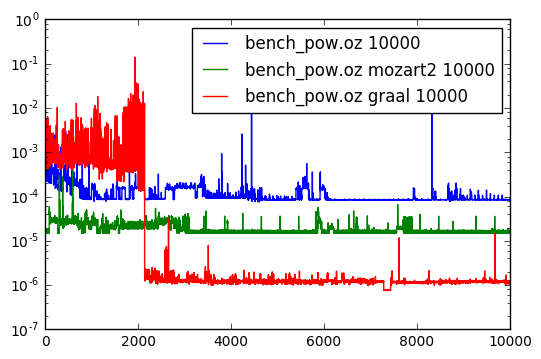

median [  8.65005000e-05   1.50740000e-05   1.23500000e-06]


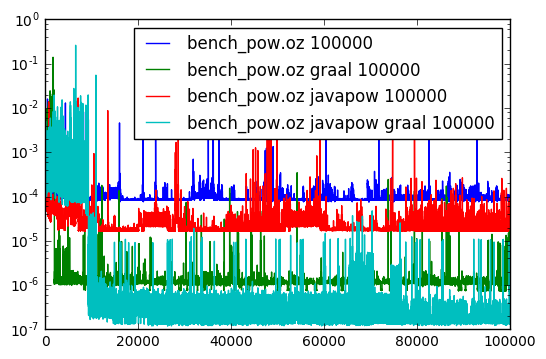

median [  8.46030000e-05   1.17600000e-06   1.76440000e-05   1.47000000e-07]


In [16]:
small()

mat, keys = plot("pow", "10000")
plt.yscale("log")
plt.legend(keys)
plt.show()
print("median", np.median(mat, axis=1))


mat, keys = plot("pow", "100000")
plt.yscale("log")
plt.legend(keys)
plt.show()
print("median", np.median(mat, axis=1))

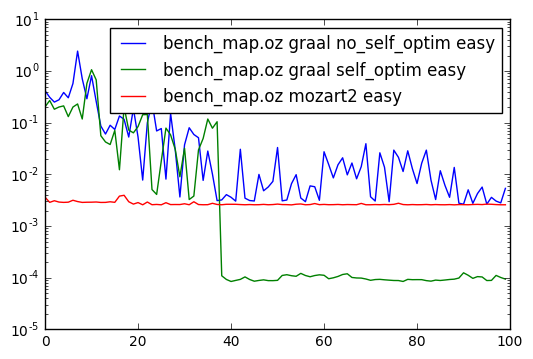

median [ 0.01235886  0.00011005  0.00261454]


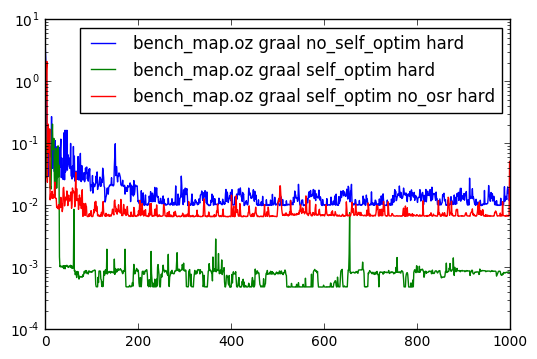

median [ 0.01272828  0.00082688  0.00692523]


In [17]:
small()

mat, keys = plot("map", "easy")
plt.yscale("log")
plt.legend(keys)
plt.show()
print("median", np.median(mat, axis=1))

mat, keys = plot("map", "hard")
plt.yscale("log")
plt.legend(keys)
plt.show()
print("median", np.median(mat, axis=1))

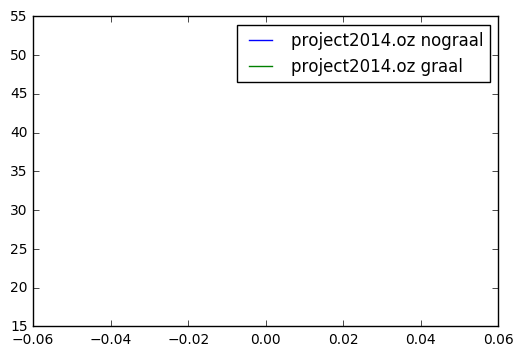

array([[ 18.0697297 ],
       [ 54.75731435]])

In [14]:
mat, keys = plot("project", "")
plt.legend(keys)
plt.show()
mat